In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn

In [2]:
class ReluModel(nn.Module):
    def __init__(self, initial_a, initial_b):
        super().__init__()
        self.a = nn.Parameter(torch.Tensor([initial_a])[0])
        self.b = nn.Parameter(torch.Tensor([initial_b])[0])
        self.relu = nn.ReLU()
        self.loss_fn = nn.MSELoss()
        
    def forward(self, x):
        return self.relu(self.a*x - self.b)

    def gradient_descent_step(self, x_batch, y_batch, step_size, parameters, losses ):
        y_batch_pred = self.forward(x_batch)
        parameters.append((float(self.a), float(self.b)))
        loss_batch = 0.5*self.loss_fn(y_batch, y_batch_pred)
        loss_batch.backward()
        losses.append(float(loss_batch))
        self.a = nn.Parameter(self.a - step_size*self.a.grad)
        self.b = nn.Parameter(self.b - step_size*self.b.grad)
        self.zero_grad()
        return self

In [3]:
def train_model(alpha, batch_size=None, scheduler=None):
    a, b = 1, 0
    x = torch.Tensor(np.arange(6)*np.pi/10)
    y = 1 - torch.cos(x)
    num_iters = 10000
    model = ReluModel(a,b)
    parameters = []
    losses = []
    for i in range(num_iters):
        
        if scheduler:
            alpha_new = scheduler(alpha, i)
        else:
            alpha_new = alpha
            
        if batch_size:
            random_index = np.random.randint(6)
            x_batch, y_batch = x[random_index:random_index+1], y[random_index:random_index+1]
        else:
            x_batch, y_batch = x, y
            
        model.gradient_descent_step(x_batch, y_batch, alpha_new, parameters, losses)
    return model, parameters, losses

In [4]:
def plot(parameters):
    plt.plot([x for x,y in parameters], [y for x,y in parameters], label="Path travelled by model parameters", color="red")
    plt.fill_between(np.arange(30,140)/100, np.pi*np.arange(30,140)/100/2, 2.4, alpha=0.5, label="Flat region")
    plt.fill_between(np.arange(30,140)/100, np.pi/10*np.arange(30,140)/100, 2*np.pi/10*np.arange(30,140)/100, alpha=0.5, label="Convex region around minimizer")
    plt.scatter(0.8612890146501079, 0.37349154462542217, label="optimal parameters", color="green")
    plt.legend()
    plt.xlabel('a')
    plt.ylabel('b')
    plt.title('a-b space')
    plt.grid()

Suppose we take $\alpha = 0.99 \alpha^∗$ and run the gradient descend. Will the
iterates approach the global minimizer?

In [5]:
alpha = 0.99*1.5099602410260962
model, parameters, losses = train_model(alpha)

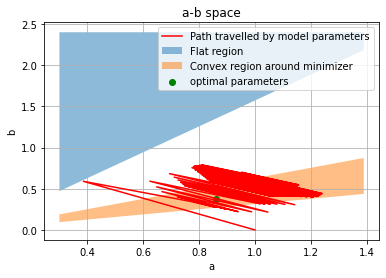

In [6]:
plot(parameters)

For $\alpha = 0.99 \alpha^*$, we see a lot of oscillation of model parameters, which suggests that the parameters may not converge, although they do not approach the flat region at any point. This is because the step size is too large to allow smooth convergence. We also see that the parameters frequently go outside the convex region, which suggests that the way to control this is to set $\alpha$ such that the parameters always stay within the convex region, since we know that gradient descent converges within the convex region.

Let us now set $\alpha$ to the maximal step size and optimal step size as derived in Bindel's notes

In [7]:
alpha = 0.8778686178666174 #Maximal step size
model, parameters, losses = train_model(alpha)

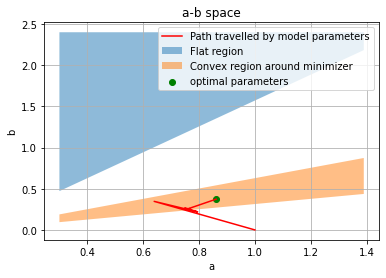

In [8]:
plot(parameters)

In [9]:
alpha = 0.8574871051410686 #Optimal step size
model, parameters, losses = train_model(alpha)

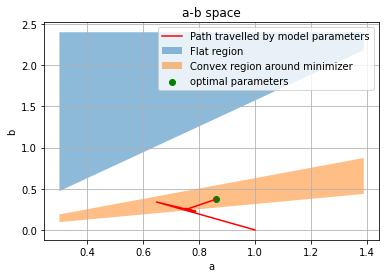

In [10]:
plot(parameters)

Now we try to optimize the given problem using stochastic gradient descent with only 1 sample per batch

This is what happens when we don't reduce step size, even for optimal $\alpha$

In [11]:
alpha = 0.8574871051410686 #Optimal step size
model, parameters, losses = train_model(alpha, 1)

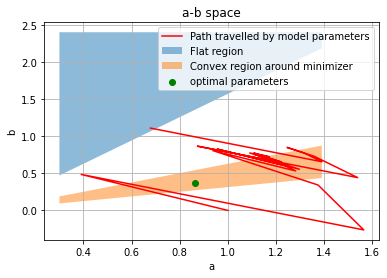

In [12]:
plot(parameters)

There is a lot of oscillation and eventually the model gets into the flat region

Lets try the same thing using a scheduler

In [54]:
def scheduler(alpha, i):
    return alpha/(i+1)**0.5
alpha = 0.45
model, parameters, losses = train_model(alpha, 1, scheduler)

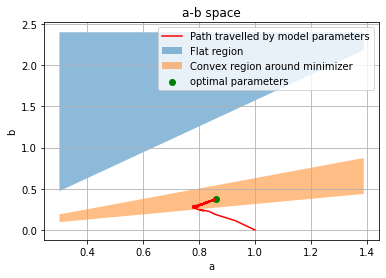

In [55]:
plot(parameters)

This converges pretty nicely, doesn't it?

Here is a figure showing the flat regions and convex regions seperated by the colored lines

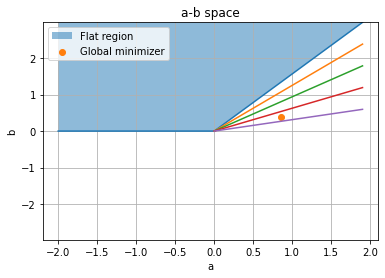

In [15]:
fig, ax = plt.subplots()
x = np.arange(-20, 20)/10
y = np.concatenate((np.zeros(len(x)//2) , np.pi/2*x[len(x)//2:]))
ax.plot(x, y)
ax.plot(x[len(x)//2:], 4*np.pi/10*x[len(x)//2:])
ax.plot(x[len(x)//2:], 3*np.pi/10*x[len(x)//2:])
ax.plot(x[len(x)//2:], 2*np.pi/10*x[len(x)//2:])
ax.plot(x[len(x)//2:], np.pi/10*x[len(x)//2:])

ax.set(xlabel='a', ylabel='b', title='a-b space')
ax.fill_between(x, y, max(y), alpha=0.5, label="Flat region")
ax.set_ylim(-max(y), max(y))
a =  0.8612890146501079
b =  0.37349154462542217
ax.scatter(a, b, label="Global minimizer")
ax.legend()
ax.grid()